In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.metrics import auc,roc_curve

from sklearn.externals import joblib
import lightgbm as lgb

from imblearn.under_sampling import RandomUnderSampler,CondensedNearestNeighbour
from imblearn.over_sampling import RandomOverSampler,SMOTE

from random import random

import matplotlib.pyplot as plt
%matplotlib inline

nrow = None
number_of_time = 10

In [2]:
train = pd.read_csv('../data/train.csv',nrows=nrow)
train.drop('ID_code',inplace= True,axis=1)

In [3]:
y = pd.DataFrame(train['target'])
#sc = MinMaxScaler()
x = pd.DataFrame(train.drop('target',axis=1),columns=train.columns[1:])

In [4]:
def features_engineer(x,y):
    x['sum'] = x.sum()
    return(x,y)

def data_augmentation(x,y,low_class_ratio = 0.2,method = 'none'):
    if method == 'random_under_sample':
        sm = RandomUnderSampler(sampling_strategy=1-low_class_ratio)
        aug_x,aug_y = sm.fit_resample(x,y)
    elif method == 'random_over_sample':
        sm = RandomOverSampler(sampling_strategy=1-low_class_ratio)
        aug_x,aug_y = sm.fit_resample(x,y)
    elif method == 'smote':
        sm = SMOTE(sampling_strategy=1-low_class_ratio,m_neighbors=10,kind='svm')
        aug_x,aug_y = sm.fit_resample(x,y)
#    elif method == 'shuffle':
        
    else:
        aug_x = x
        aug_y = y
    
    return(pd.DataFrame(aug_x,columns=x.columns),pd.DataFrame(aug_y,columns=['target']))

In [5]:
#test = pd.read_csv('../data/test.csv')
#sub = pd.DataFrame()
#sub['ID_code'] = test['ID_code']
#test.drop('ID_code',axis=1,inplace=True)
train,test = train_test_split(train,test_size = 0.3)

In [6]:
train_x = train.drop('target',axis=1).reset_index(drop=True)
train_y = pd.DataFrame(train['target']).reset_index(drop=True)

In [7]:
#predict and combine
def models_list_predict(models,test_x):
    res = np.zeros((test.shape[0]))
    for model in models:
        res = res + model.predict(test_x)
    res = res/len(models)
    return(res)

def combine_pred(x,y,test_x):
    pred = np.zeros((test.shape[0]))
    for i in range(number_of_time):
        model = k_fold_train(x,y,'none',random()/2)
        pred = pred + model.predict(test_x)

    pred = pred/number_of_time
    return(pred)

In [8]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.2,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.041,
    'learning_rate': 0.003,
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'objective': 'binary',
    'tree_learner': 'serial',
    "verbosity" : 1,
    "bagging_seed" : 15,
    "seed": 15
}
def k_fold_train(x,y,sample_method = 'none'):
    kf = StratifiedKFold(n_splits=3,shuffle=True)
    models = []
    for train_index,val_index in kf.split(x,y):
        train_model_x,val_model_x = x.iloc[train_index,:],x.iloc[val_index,:]
        train_model_y,val_model_y = y.iloc[train_index],y.iloc[val_index]
        n_x,n_y = data_augmentation(train_model_x,train_model_y,method=sample_method,low_class_ratio=random()/2+0.1)
        train_data = lgb.Dataset(n_x,n_y)
        val_data = lgb.Dataset(val_model_x,val_model_y)
        
        model = lgb.train(param,train_set=train_data,num_boost_round=100000,verbose_eval = 100,
                          early_stopping_rounds=1000,valid_sets = [train_data,val_data])
        models.append(model)
    return(models)

In [10]:
base_line = k_fold_train(train_x,train_y)

Training until validation scores don't improve for 1000 rounds.
[100]	training's auc: 0.861227	valid_1's auc: 0.843378
[200]	training's auc: 0.884062	valid_1's auc: 0.866247
[300]	training's auc: 0.891612	valid_1's auc: 0.873653
[400]	training's auc: 0.894793	valid_1's auc: 0.877284
[500]	training's auc: 0.896831	valid_1's auc: 0.880121
[600]	training's auc: 0.898045	valid_1's auc: 0.881626
[700]	training's auc: 0.899257	valid_1's auc: 0.883061
[800]	training's auc: 0.900219	valid_1's auc: 0.883682
[900]	training's auc: 0.900787	valid_1's auc: 0.88457
[1000]	training's auc: 0.901761	valid_1's auc: 0.884923
[1100]	training's auc: 0.902404	valid_1's auc: 0.885746
[1200]	training's auc: 0.90275	valid_1's auc: 0.885289
[1300]	training's auc: 0.903485	valid_1's auc: 0.886464
[1400]	training's auc: 0.904214	valid_1's auc: 0.88728
[1500]	training's auc: 0.904993	valid_1's auc: 0.887675
[1600]	training's auc: 0.904834	valid_1's auc: 0.887595
[1700]	training's auc: 0.905357	valid_1's auc: 0.888

[14600]	training's auc: 0.933087	valid_1's auc: 0.900402
[14700]	training's auc: 0.933245	valid_1's auc: 0.900424
[14800]	training's auc: 0.933405	valid_1's auc: 0.900458
[14900]	training's auc: 0.933531	valid_1's auc: 0.900477
[15000]	training's auc: 0.933671	valid_1's auc: 0.900521
[15100]	training's auc: 0.933822	valid_1's auc: 0.900538
[15200]	training's auc: 0.933976	valid_1's auc: 0.900582
[15300]	training's auc: 0.934121	valid_1's auc: 0.90058
[15400]	training's auc: 0.934281	valid_1's auc: 0.900605
[15500]	training's auc: 0.93443	valid_1's auc: 0.900642
[15600]	training's auc: 0.934556	valid_1's auc: 0.900671
[15700]	training's auc: 0.934685	valid_1's auc: 0.900696
[15800]	training's auc: 0.934825	valid_1's auc: 0.900722
[15900]	training's auc: 0.93497	valid_1's auc: 0.900741
[16000]	training's auc: 0.935109	valid_1's auc: 0.900763
[16100]	training's auc: 0.935246	valid_1's auc: 0.900773
[16200]	training's auc: 0.935383	valid_1's auc: 0.900784
[16300]	training's auc: 0.93553	va

[8100]	training's auc: 0.923074	valid_1's auc: 0.896244
[8200]	training's auc: 0.923239	valid_1's auc: 0.896307
[8300]	training's auc: 0.923412	valid_1's auc: 0.896394
[8400]	training's auc: 0.923584	valid_1's auc: 0.896455
[8500]	training's auc: 0.923766	valid_1's auc: 0.896529
[8600]	training's auc: 0.923964	valid_1's auc: 0.896605
[8700]	training's auc: 0.924141	valid_1's auc: 0.896664
[8800]	training's auc: 0.92434	valid_1's auc: 0.896746
[8900]	training's auc: 0.92456	valid_1's auc: 0.896848
[9000]	training's auc: 0.924743	valid_1's auc: 0.896852
[9100]	training's auc: 0.924937	valid_1's auc: 0.896905
[9200]	training's auc: 0.925106	valid_1's auc: 0.896976
[9300]	training's auc: 0.925295	valid_1's auc: 0.897033
[9400]	training's auc: 0.925456	valid_1's auc: 0.897069
[9500]	training's auc: 0.925632	valid_1's auc: 0.897099
[9600]	training's auc: 0.925818	valid_1's auc: 0.897162
[9700]	training's auc: 0.925966	valid_1's auc: 0.897211
[9800]	training's auc: 0.926144	valid_1's auc: 0.8

[2600]	training's auc: 0.909972	valid_1's auc: 0.888832
[2700]	training's auc: 0.910404	valid_1's auc: 0.889089
[2800]	training's auc: 0.910752	valid_1's auc: 0.889246
[2900]	training's auc: 0.911133	valid_1's auc: 0.889546
[3000]	training's auc: 0.91149	valid_1's auc: 0.88985
[3100]	training's auc: 0.911775	valid_1's auc: 0.890027
[3200]	training's auc: 0.912052	valid_1's auc: 0.890185
[3300]	training's auc: 0.912402	valid_1's auc: 0.890387
[3400]	training's auc: 0.912597	valid_1's auc: 0.890447
[3500]	training's auc: 0.912897	valid_1's auc: 0.89065
[3600]	training's auc: 0.913013	valid_1's auc: 0.890732
[3700]	training's auc: 0.913226	valid_1's auc: 0.890928
[3800]	training's auc: 0.913475	valid_1's auc: 0.891087
[3900]	training's auc: 0.913777	valid_1's auc: 0.891255
[4000]	training's auc: 0.913964	valid_1's auc: 0.891301
[4100]	training's auc: 0.914302	valid_1's auc: 0.891465
[4200]	training's auc: 0.914615	valid_1's auc: 0.89165
[4300]	training's auc: 0.914809	valid_1's auc: 0.891

[17200]	training's auc: 0.937596	valid_1's auc: 0.898665
[17300]	training's auc: 0.937737	valid_1's auc: 0.898691
[17400]	training's auc: 0.937858	valid_1's auc: 0.898706
[17500]	training's auc: 0.938007	valid_1's auc: 0.898719
[17600]	training's auc: 0.938132	valid_1's auc: 0.898727
[17700]	training's auc: 0.938256	valid_1's auc: 0.898731
[17800]	training's auc: 0.938382	valid_1's auc: 0.898741
[17900]	training's auc: 0.938496	valid_1's auc: 0.898743
[18000]	training's auc: 0.938617	valid_1's auc: 0.898731
[18100]	training's auc: 0.93875	valid_1's auc: 0.898741
[18200]	training's auc: 0.938873	valid_1's auc: 0.89873
[18300]	training's auc: 0.939012	valid_1's auc: 0.898731
[18400]	training's auc: 0.939145	valid_1's auc: 0.898747
[18500]	training's auc: 0.939272	valid_1's auc: 0.898745
[18600]	training's auc: 0.939387	valid_1's auc: 0.898758
[18700]	training's auc: 0.939519	valid_1's auc: 0.898753
[18800]	training's auc: 0.939661	valid_1's auc: 0.898782
[18900]	training's auc: 0.939793	

In [10]:
#random_under = k_fold_train(train_x,train_y,'random_under_sample')

In [ ]:
random_over = k_fold_train(train_x,train_y,'random_over_sample')

In [12]:
#smote = k_fold_train(train_x,train_y,'smote')

In [13]:
def plotGraph(df):
    predicts_list = df.columns[1:]
    aucs = pd.DataFrame(columns=['models','auc_score'])
    y = df['label']
    for res in predicts_list:
        fpr,tpr,thres = roc_curve(y,df[res])
        auc_score = auc(fpr,tpr)
        aucs = aucs.append({'models':res,'auc_score':auc_score},ignore_index=True)
        
        plt.plot(fpr,tpr,lw=1, alpha=0.3,label = res+' : '+str(round(auc_score,3)))
    
    plt.legend(loc='lower right')
    plt.show()
    return(aucs)

In [14]:
pred = models_list_predict(base_line,test.drop('target',axis=1))

result_df = pd.DataFrame()
result_df['label'] = test['target']
result_df['base'] = pred

In [15]:
#pred = random_under.predict(test.drop('target',axis=1))
#result_df['random_under'] = pred

pred = models_list_predict(random_over,test.drop('target',axis=1))
result_df['random_over'] = pred

#pred = models_list_predict(smote,test.drop('target',axis=1))
#result_df['smote'] = pred

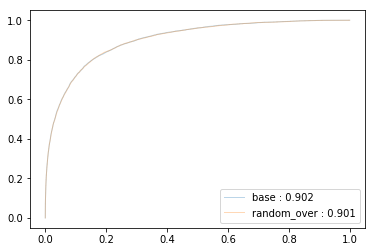

,models,auc_score
0,base,0.901732
1,random_over,0.901306


In [16]:
plotGraph(result_df)

In [11]:
#final_pred = combine_pred(x,y,test)
final_pred = models_list_predict(base_line,test)

In [12]:
sub['target'] = final_pred
sub.to_csv("../data/models_list_pred_base.csv",index=False)